In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import RFECV
import xgboost as xgb
from xgboost_distribution import XGBDistribution

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="ambient-sylph-426620-g6") # Odele

### 1. Querying product sales from GA

In [17]:
query = '''
    WITH purchases AS(
        SELECT distinct
            fullVisitorId AS user_id
            ,PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) AS datetime
            ,product.productSKU AS product_id
            ,product.v2ProductName AS product_name
            ,product.v2ProductCategory AS product_category
            ,product.productPrice/1000000 AS product_price
            ,product.productQuantity AS product_qty
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits
        LEFT JOIN UNNEST(hits.product) AS product ON TRUE
        WHERE true
            and hits.eCommerceAction.action_type  = '6'
            and product.productQuantity > 0
            and PARSE_DATETIME("%Y%m%d %H:%M:%S", CONCAT(date, ' ' ,hour,':',minute,':00')) < date '2017-08-01'
    )
    SELECT 
        date_trunc(datetime, day) AS ymd
        ,product_id
        ,product_name
        ,product_category AS product_category_temp
        ,product_price
        ,SUM(product_qty) AS daily_qty
        ,COUNT(distinct user_id) AS daily_user_cnt
    FROM purchases
    GROUP BY 2,1,3,4,5
    ORDER BY 1,2,3
    
'''

rows = client.query(query)
daily_sales = rows.to_dataframe()
raw_ga_data = rows.to_dataframe()

In [23]:
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])
daily_sales.replace('(not set)', np.nan, inplace = True)
daily_sales['product_category_temp'].replace('${productitem.product.origCatName}', np.nan, inplace = True)
daily_sales['product_category_temp'].replace(['Tumblers', 'Bottles', 'Google'], 'Drinkware', inplace = True)
daily_sales['product_category_temp'].replace(['More Bags', 'Backpacks'], 'Bags', inplace = True)
daily_sales['product_category_temp'].replace('Android', 'Apparel', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"Waze.*(Men's|Women's|Socks)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales['product_category_temp'].replace('Waze', 'Office', inplace = True)
daily_sales.loc[daily_sales["product_name"].str.contains(r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case = True, na = False), "product_category_temp"] = "Apparel"
daily_sales.loc[daily_sales["product_name"].str.contains(r"(oz|Bottle|Cup|Mug)", case = True, na = False), "product_category_temp"] = "Drinkware"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Journal|Notebook", case = True, na = False), "product_category_temp"] = "Notebooks & Journals"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Bag|Backpack|Tote|Rucksack", case = True, na = False), "product_category_temp"] = "Bags"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Gift Card", case = True, na = False), "v"] = "Gift Cards"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Electronics|Device|Headphones|Earbuds|Earphones|Power Bank|Speaker", case = True, na = False), "product_category_temp"] = "Electronics"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Cap|Hat", case = True, na = False), "product_category_temp"] = "Headgear"
daily_sales.loc[daily_sales["product_name"].str.contains(r"Pen", case = True, na = False), "product_category_temp"] = "Office"
daily_sales["product_id"] = daily_sales['product_id'].astype("string")
product_category_mode = daily_sales.groupby(["product_id", "product_price"])["product_category_temp"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index(name="product_category")
daily_sales = daily_sales.merge(product_category_mode, on = ["product_id", "product_price"], how = "left")
daily_sales = daily_sales.groupby(["ymd", "product_id", "product_price", "product_category"])[["daily_qty", "daily_user_cnt"]].sum().reset_index()

daily_sales.dropna(subset = ['product_category'], inplace = True)


### 2. Generating synthetic data for Mar - Jul 2016 (skip this section and use the .csv file in section 3)

In [24]:
import itertools
daily_sales["ymd"] = pd.to_datetime(daily_sales["ymd"])

def get_month_products(dates, month, product_prices, sales):
    date_product_price_df = pd.DataFrame(
        list(itertools.product(dates, product_prices.to_records(index=False))),
        columns=['ymd', 'product_price_pair']
    )
    date_product_price_df['product_id'] = date_product_price_df['product_price_pair'].apply(lambda x: x[0])
    date_product_price_df['product_price'] = date_product_price_df['product_price_pair'].apply(lambda x: x[1])
    date_product_price_df.drop({'product_price_pair'}, axis = 1, inplace = True)
    month_sales = pd.merge(date_product_price_df, daily_sales, how='left', on=['ymd', 'product_id', 'product_price']).fillna(0)

    return pd.concat([sales, month_sales], axis=0)

mar_dates = pd.date_range(start='2017-03-01',  end='2017-03-31', freq ='D')
mar_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 3, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
apr_dates = pd.date_range(start='2017-04-01',  end='2017-04-30', freq ='D')
apr_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 4, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
may_dates = pd.date_range(start='2017-05-01',  end='2017-05-31', freq ='D')
may_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 5, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jun_dates = pd.date_range(start='2017-06-01',  end='2017-06-30', freq ='D')
jun_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 6, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()
jul_dates = pd.date_range(start='2017-07-01',  end='2017-07-31', freq ='D')
jul_product_prices = daily_sales.loc[daily_sales['ymd'].dt.month == 7, ['product_id', 'product_price']][['product_id', 'product_price']].drop_duplicates()

mar_jul_sales = pd.DataFrame()
mar_jul_sales = get_month_products(mar_dates, 3, mar_product_prices, mar_jul_sales)
mar_jul_sales = get_month_products(apr_dates, 4, apr_product_prices, mar_jul_sales)
mar_jul_sales = get_month_products(may_dates, 5, may_product_prices, mar_jul_sales)
mar_jul_sales = get_month_products(jun_dates, 6, jun_product_prices, mar_jul_sales)
mar_jul_sales = get_month_products(jul_dates, 7, jul_product_prices, mar_jul_sales)

In [25]:
np.random.seed(123)
synthetic_data = pd.DataFrame()

months = [3, 4, 5, 6, 7]

for month in months:
    products = mar_jul_sales[mar_jul_sales['ymd'].dt.month == month]['product_id'].unique()
    for product in products:
        prices = mar_jul_sales[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product)]['product_price'].unique()
        for price in prices:

            monthly_sales_qty = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price), ['daily_qty']]
            monthly_sales_user_cnt = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price), ['daily_user_cnt']]

            n_train = monthly_sales_qty.shape[0]
 
            m = mar_jul_sales.loc[(mar_jul_sales['ymd'].dt.month == month) & (mar_jul_sales['product_id'] == product) & (mar_jul_sales['product_price'] == price)]
            # print(f'price {price} for product {product} for month {month} with {m['daily_qty'].sum()} in month and {m['daily_user_cnt'].sum()} users')

            m['daily_avg_qty'] = m.apply(lambda row: row['daily_qty'] / row['daily_user_cnt'] if row['daily_user_cnt'] > 0 else 0, axis=1)
            lambda_qty = m['daily_qty'].mean()
            lambda_user_cnt = m['daily_user_cnt'].mean()
            lambda_avg_qty = m['daily_avg_qty'].mean()
            lambda_avg_qty_i = np.random.poisson(lambda_avg_qty)
            sample_qty = np.random.poisson(lambda_qty, n_train)
            sample_user_cnt = np.random.poisson(lambda_user_cnt, n_train)
            # print(f'qty: {sample_qty.sum()}, user: {sample_user_cnt.sum()}, avg_qty : {lambda_avg_qty_i}')

            if (sample_user_cnt.sum() == 0 and sample_qty.sum() != 0):
                # print(f'Dividing {sample_qty.sum()} by {lambda_avg_qty_i}')
                sample_qty_spec = sample_qty.sum()
                sample_user_cnt_spec = (sample_qty.sum()//lambda_avg_qty_i).astype(int)
                if sample_user_cnt_spec == 0:
                    sample_qty_spec = 0
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price],
                                        'present_user_cnt': sample_user_cnt_spec, 'present_total_qty': sample_qty_spec})
                # print(f'qty: {sample_qty_spec}, user: {sample_user_cnt_spec}')

            elif (sample_user_cnt.sum() > sample_qty.sum()) or (sample_user_cnt.sum() != 0 and sample_qty.sum() == 0):
                sample_user_cnt_spec = sample_user_cnt.sum()
                #print(f'multiplying {sample_user_cnt.sum()} by {lambda_avg_qty_i}')
                sample_qty_spec = (sample_user_cnt.sum()*(lambda_avg_qty_i)).astype(int)
                if sample_qty_spec == 0:
                    sample_user_cnt_spec = 0
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt_spec, 'present_total_qty': sample_qty_spec})
                # print(f'qty: {sample_qty_spec}, user: {sample_user_cnt_spec}')
            elif sample_user_cnt.sum() < 0  or sample_qty.sum() < 0:
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': 0, 'present_total_qty': 0})
            else:
                month_data = pd.DataFrame({'year_month': f'2016-0{month}-01', 'product_id': product, 'product_price': [price], 
                                        'present_user_cnt': sample_user_cnt.sum(), 'present_total_qty': sample_qty.sum()})
 
            synthetic_data = pd.concat([synthetic_data, month_data], ignore_index = True)


In [26]:
synthetic_data.to_csv('raw_synthetic_v3.csv', index=False)

#### Checking quality of synthetic data

In [27]:
mar_jul_sales_monthly = mar_jul_sales.copy()
mar_jul_sales_monthly['year_month'] = mar_jul_sales_monthly['ymd'].dt.strftime('%Y-%m')
mar_jul_sales_monthly = mar_jul_sales_monthly.groupby(['year_month', 'product_category'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
mar_jul_sales_monthly = mar_jul_sales_monthly.loc[mar_jul_sales_monthly['product_category'] != 0]
mar_jul_sales_monthly.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis = 1, inplace = True)

synthetic_data_check = synthetic_data.copy()
synthetic_data_check = pd.merge(synthetic_data_check, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
synthetic_data_check = synthetic_data_check.groupby(['year_month', 'product_category'])[['present_user_cnt', 'present_total_qty']].sum().reset_index()
synthetic_data_check['year_month'] = pd.to_datetime(synthetic_data_check['year_month']).dt.strftime('%Y-%m')
synthetic_data_check_full = pd.concat([mar_jul_sales_monthly, synthetic_data_check], axis = 0)
synthetic_data_check_full['batch'] = synthetic_data_check_full['year_month'].apply(lambda x: 'Original' if x[:4] == '2017' else 'Synthetic')

Text(0.5, 0.98, 'Violin Plots to Compare Distribution of Synthetic and Original Demand')

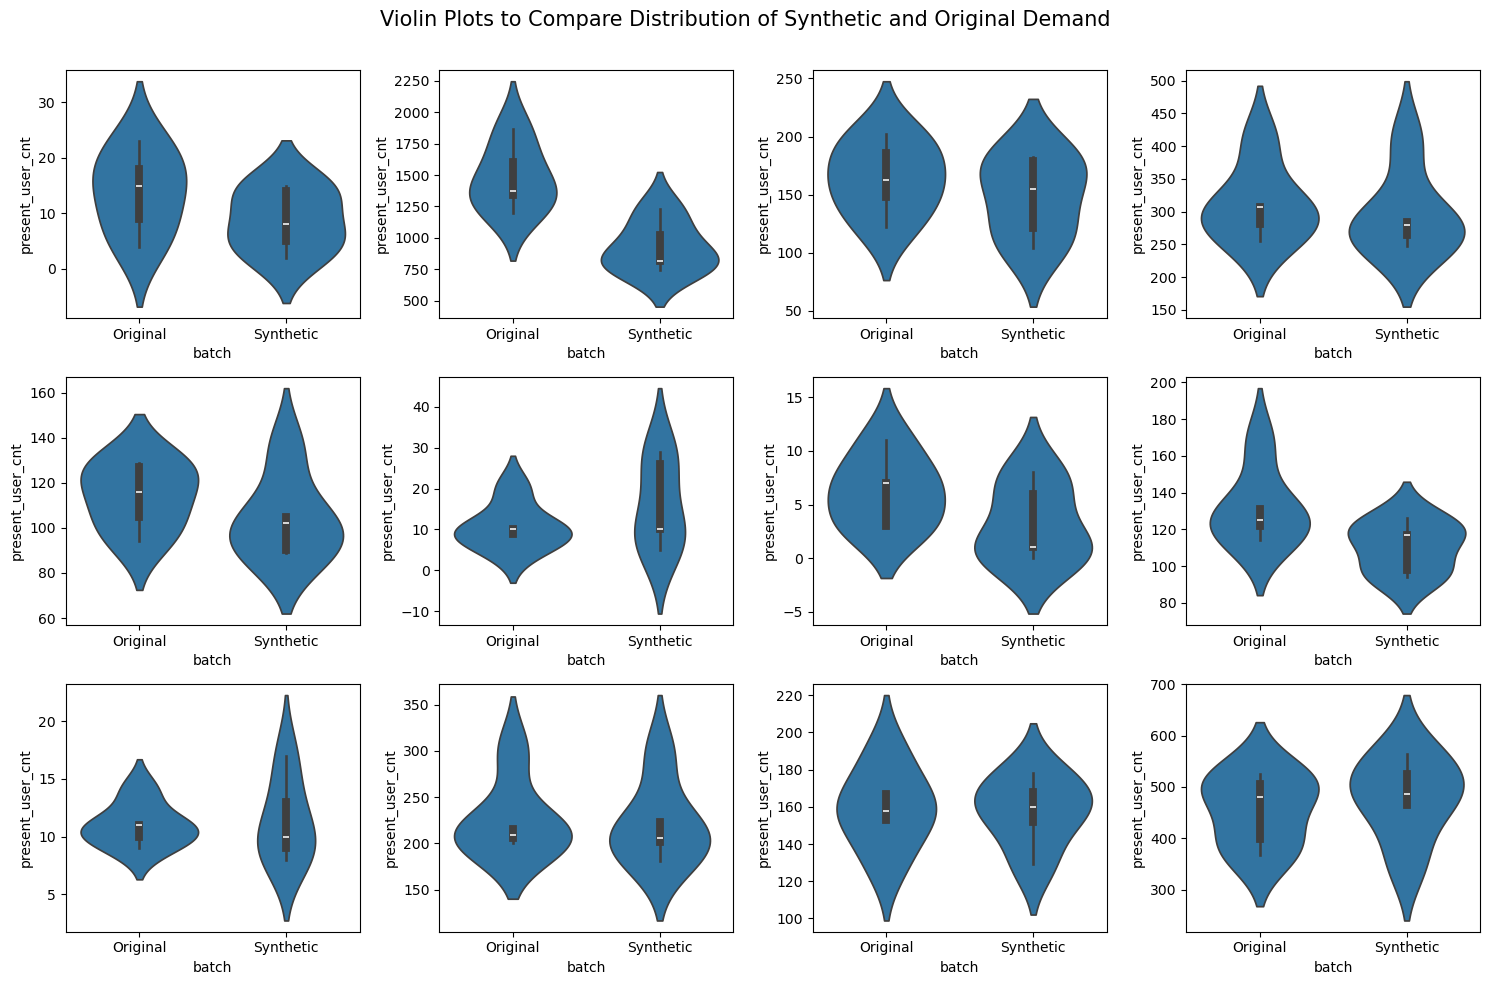

In [28]:
fig1, axes1 = plt.subplots(3, 4, figsize=(15, 10))
categories = synthetic_data_check_full['product_category'].unique()

i=0
j=0
for category in categories:
    sns.violinplot(data = synthetic_data_check_full.loc[synthetic_data_check_full['product_category'] == category], x = 'batch', y = 'present_user_cnt', ax = axes1[i, j])
    if j != 3:
        j += 1
    else:
        i += 1
        j = 0

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Violin Plots to Compare Distribution of Synthetic and Original Demand', fontsize = 15)

Text(0.5, 0.98, 'Violin Plots to Compare Distribution of Synthetic and Original User Count')

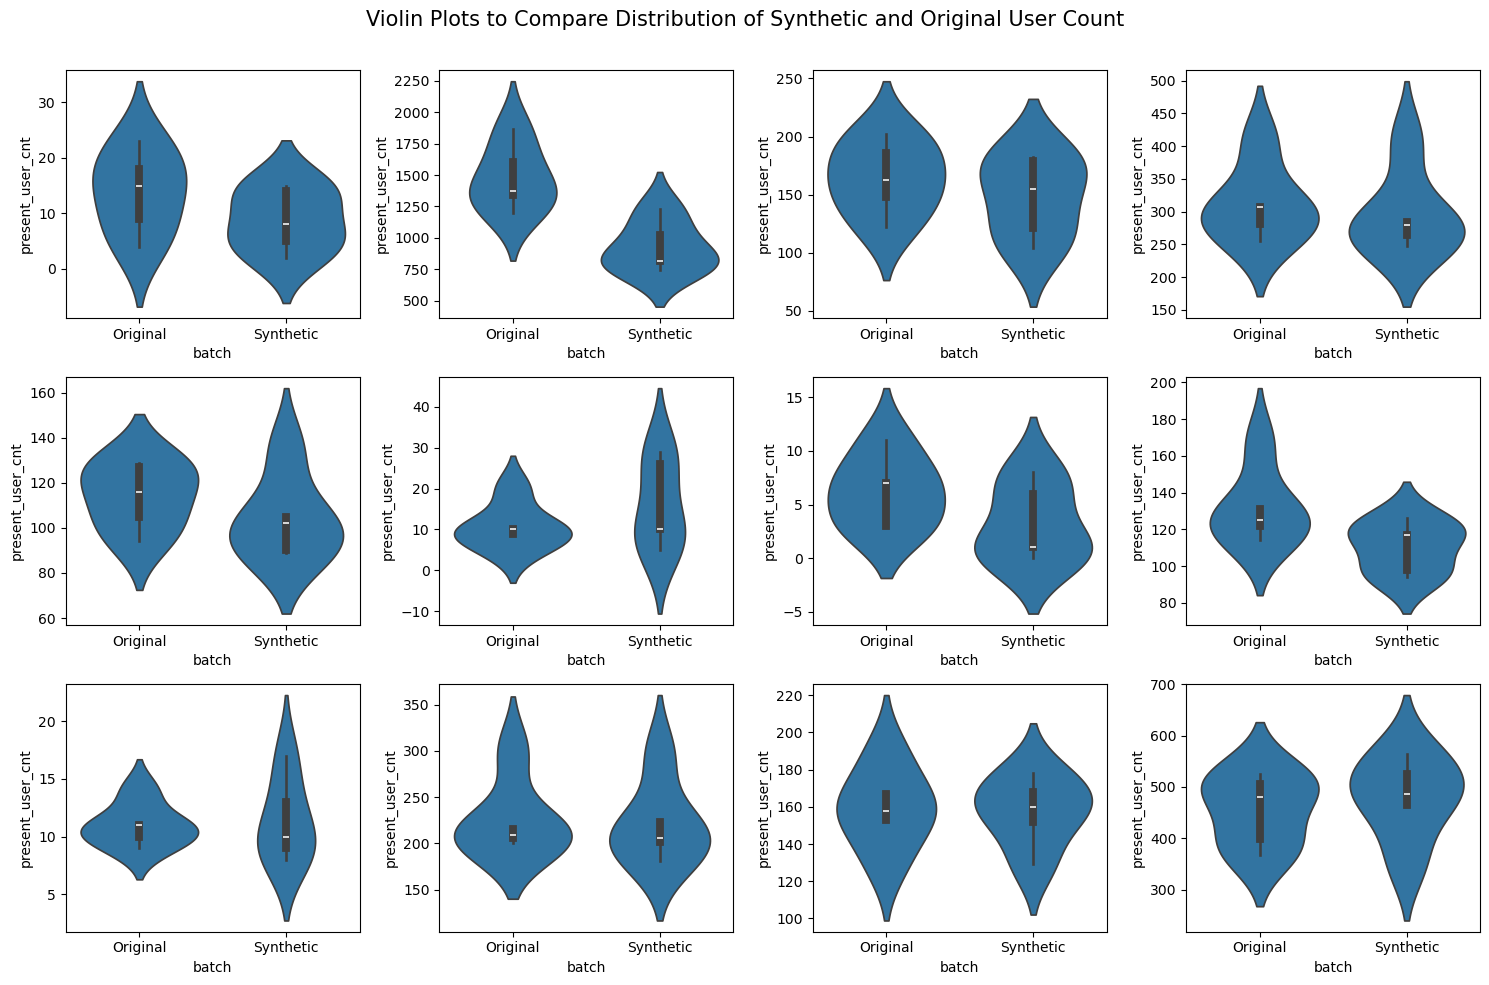

In [29]:
fig2, axes2 = plt.subplots(3, 4, figsize=(15, 10))
categories = synthetic_data_check_full['product_category'].unique()

i=0
j=0
for category in categories:
    sns.violinplot(data = synthetic_data_check_full.loc[synthetic_data_check_full['product_category'] == category], x = 'batch', y = 'present_user_cnt', ax = axes2[i, j])
    if j != 3:
        j += 1
    else:
        i += 1
        j = 0

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle('Violin Plots to Compare Distribution of Synthetic and Original User Count', fontsize = 15)

In [30]:
synthetic_data = pd.merge(synthetic_data, daily_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on = ['product_id', 'product_price'], how = 'left')
column_order = ['year_month', 'product_id', 'product_category', 'product_price', 'present_user_cnt', 'present_total_qty']
synthetic_data = synthetic_data[column_order]
synthetic_data['year_month'] = pd.to_datetime(synthetic_data['year_month']).dt.to_period('M').dt.to_timestamp()
# synthetic_data.to_csv('cleaned_synthetic_v3.csv', index = False)

### 3. Data cleaning

In [31]:
synthetic_data = pd.read_csv('cleaned_synthetic_v3.csv')

In [32]:
daily_sales['year_month'] = daily_sales['ymd'].dt.to_period('M').dt.to_timestamp()
monthly_sales = daily_sales.groupby(['year_month','product_id', 'product_category', 'product_price'])[['daily_qty', 'daily_user_cnt']].sum().reset_index()
monthly_sales.rename({'daily_qty': 'present_total_qty', 'daily_user_cnt': 'present_user_cnt'}, axis=1, inplace=True)
all_monthly_sales = pd.concat([monthly_sales, synthetic_data], ignore_index = True)
all_monthly_sales['year_month'] = pd.to_datetime(all_monthly_sales['year_month']).dt.to_period('M').dt.to_timestamp()
all_monthly_sales

,year_month,product_id,product_category,product_price,present_total_qty,present_user_cnt
0,2016-08-01,GGOEAAAB034813,Apparel,16.99,1,1
1,2016-08-01,GGOEAAAB034814,Apparel,13.59,1,1
2,2016-08-01,GGOEAAAB034814,Apparel,16.99,2,2
3,2016-08-01,GGOEAAAB034815,Apparel,13.59,1,1
4,2016-08-01,GGOEAAAB034815,Apparel,16.99,1,1
...,...,...,...,...,...,...
15474,2016-07-01,GGOEGAEJ028115,Apparel,4.08,6,1
15475,2016-07-01,GGOEGALJ057913,Apparel,22.00,0,0
15476,2016-07-01,GGOEYAEA035116,Apparel,12.00,0,0
15477,2016-07-01,GGOEYAEJ029015,Apparel,18.99,1,1


In [33]:
# Make sure that each product-price pair appears in all months
all_months = pd.date_range(start='2016-03-01', end='2017-07-01', freq='MS')
unique_products = all_monthly_sales['product_id'].drop_duplicates()
months_products_combos = pd.MultiIndex.from_product([unique_products, all_months], names=['product_id', 'year_month'])
months_products_combos = pd.DataFrame(index = months_products_combos).reset_index()
months_products_combos['year_month'] = pd.to_datetime(months_products_combos['year_month']).dt.to_period('M').dt.to_timestamp()
months_products_price = pd.merge(months_products_combos, all_monthly_sales[['product_id', 'product_price', 'product_category']].drop_duplicates(), on  = 'product_id', how = 'left')
all_months_products = pd.merge(months_products_price, all_monthly_sales, on = ['product_id', 'product_price', 'year_month','product_category'], how = 'left')

all_months_products[['present_total_qty', 'present_user_cnt']] = all_months_products[['present_total_qty', 'present_user_cnt']].fillna(0)
all_months_products['year_month'] = pd.to_datetime(all_months_products['year_month'])
all_months_products['month'] = all_months_products['year_month'].dt.strftime('%b')

In [34]:
qty_sd = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].std().reset_index(name = 'total_qty_sd')
user_cnt_sd = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].std().reset_index(name = 'user_cnt_sd')

all_months_products = all_months_products.merge(qty_sd, on = ['product_id', 'product_price'], how = 'left')
all_months_products = all_months_products.merge(user_cnt_sd, on = ['product_id', 'product_price'], how = 'left')

### 4. EDA

In [35]:
colors = [
    '#1f77b4',  # Muted Blue
    '#ff7f0e',  # Muted Orange
    '#2ca02c',  # Muted Green
    '#d62728',  # Muted Red
    '#9467bd',  # Muted Purple
    '#8c564b',  # Brownish
    '#e377c2',  # Soft Pink
    '#7f7f7f',  # Medium Grey
    '#bcbd22',  # Olive Green
    '#17becf',  # Teal
    '#c5b0d5',  # Soft Lavender
    '#4682b4'   # Steel Blue (replacing Khaki)
]

Top sales (by quantity) per month

In [36]:
top_sales = all_months_products.sort_values(['year_month', 'present_total_qty'], ascending = [True, False]).groupby(['year_month']).head(1)
top_sales = pd.merge(top_sales, raw_ga_data[['product_id', 'product_name']].drop_duplicates(), on = 'product_id', how = 'left')
top_sales[['year_month', 'product_name', 'product_price', 'present_total_qty', 'present_user_cnt']]

,year_month,product_name,product_price,present_total_qty,present_user_cnt
0,2016-03-01,Maze Pen,0.99,728,20
1,2016-04-01,Maze Pen,0.99,1343,26
2,2016-05-01,Maze Pen,0.99,550,17
3,2016-06-01,Maze Pen,0.79,2437,11
4,2016-07-01,22 oz Mini Mountain Bottle,2.99,1144,21
5,2016-07-01,Google 22 oz Water Bottle,2.99,1144,21
6,2016-08-01,Maze Pen,0.99,870,21
7,2016-09-01,Blue Metallic Textured Spiral Notebook Set,4.79,811,21
8,2016-09-01,Google Metallic Notebook Set,4.79,811,21
9,2016-10-01,Maze Pen,0.99,1910,29


Text(0, 0.5, 'Number of Buyers')

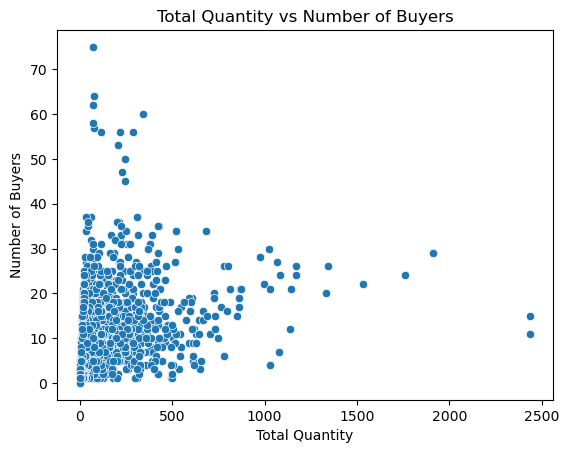

In [37]:
sns.scatterplot(data = all_months_products, x = 'present_total_qty', y = 'present_user_cnt')
plt.title('Total Quantity vs Number of Buyers')
plt.xlabel('Total Quantity')
plt.ylabel('Number of Buyers')

Top sales (by buyer count) per month

In [38]:
most_buyers = all_months_products.sort_values(['year_month', 'present_user_cnt'], ascending = [True, False]).groupby(['year_month']).head(1).reset_index()
most_buyers = pd.merge(most_buyers, raw_ga_data[['product_id', 'product_name']].drop_duplicates(), on = 'product_id', how = 'left')
most_buyers[['year_month', 'product_name', 'product_price', 'present_total_qty', 'present_user_cnt']]

,year_month,product_name,product_price,present_total_qty,present_user_cnt
0,2016-03-01,Google Heavyweight Long Sleeve Hero Tee Navy,39.99,64,32
1,2016-03-01,Google Men's Heavyweight Long Sleeve Hero Tee ...,39.99,64,32
2,2016-04-01,Google Sunglasses,2.80,226,31
3,2016-04-01,Google Sunglasses Blue,2.80,226,31
4,2016-05-01,BLM Sweatshirt,33.59,75,58
5,2016-06-01,Google Laptop and Cell Phone Stickers,2.99,383,31
6,2016-07-01,Google Spiral Journal with Pen,7.99,75,75
7,2016-08-01,Google Laptop and Cell Phone Stickers,1.99,209,53
8,2016-09-01,Google Laptop and Cell Phone Stickers,1.99,219,56
9,2016-10-01,Google Laptop and Cell Phone Stickers,1.99,291,56


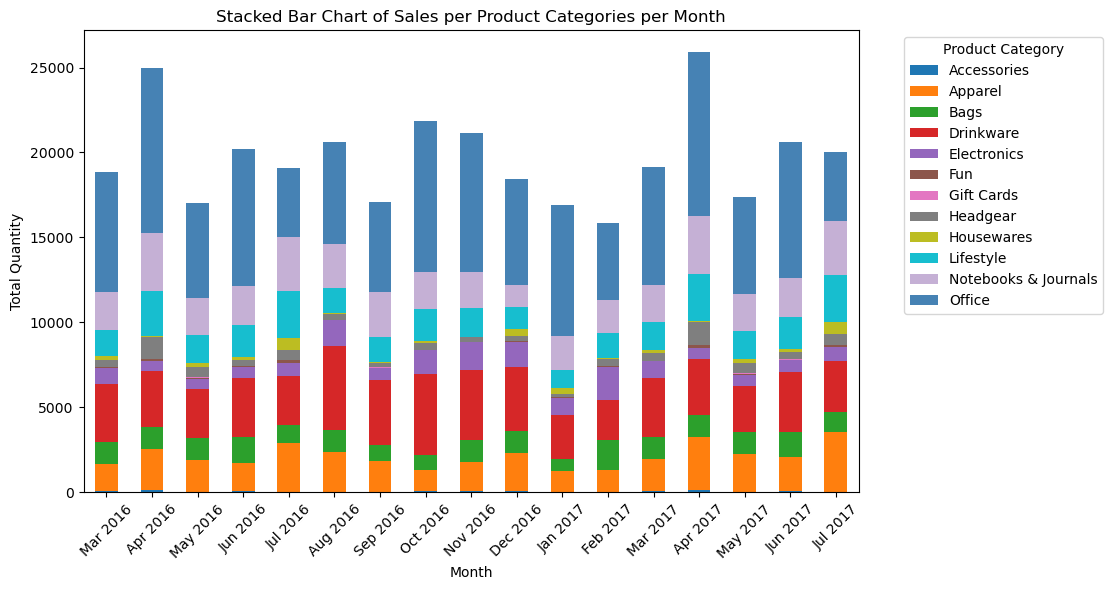

In [39]:
ax1 = all_months_products.groupby(['year_month', 'product_category'])['present_total_qty'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
ax1.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Quantity')
plt.xlabel('Month')
plt.title('Stacked Bar Chart of Sales per Product Categories per Month')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')


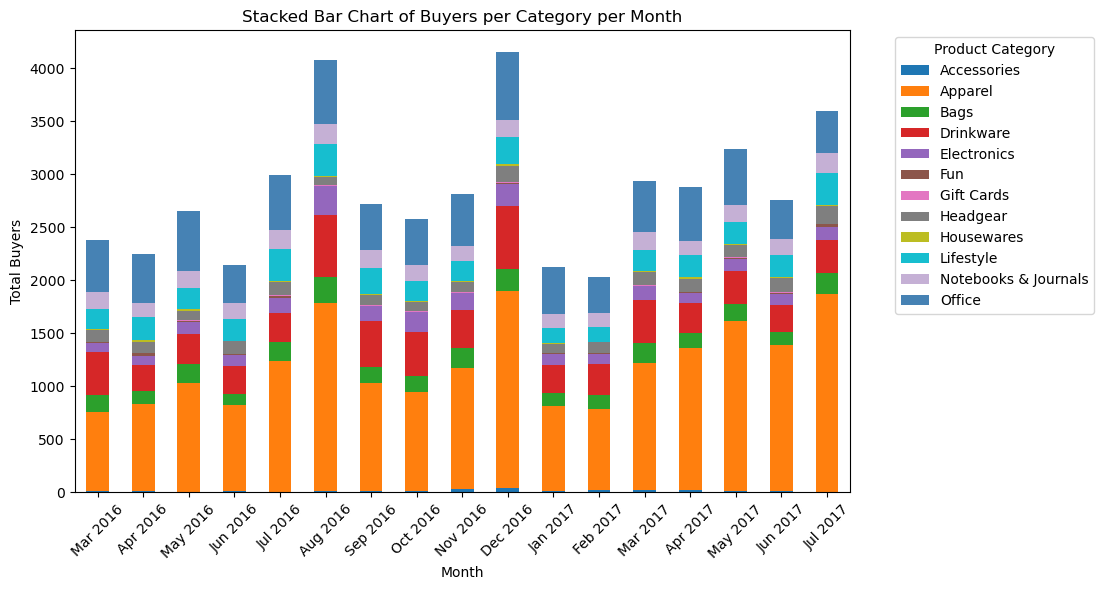

In [40]:
ax2 = all_months_products.groupby(['year_month', 'product_category'])['present_user_cnt'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
ax2.set_xticklabels(all_months_products['year_month'].dt.strftime('%b %Y').unique())
plt.ylabel('Total Buyers')
plt.xlabel('Month')
plt.title('Stacked Bar Chart of Buyers per Category per Month')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0, 0.5, 'Product Category')

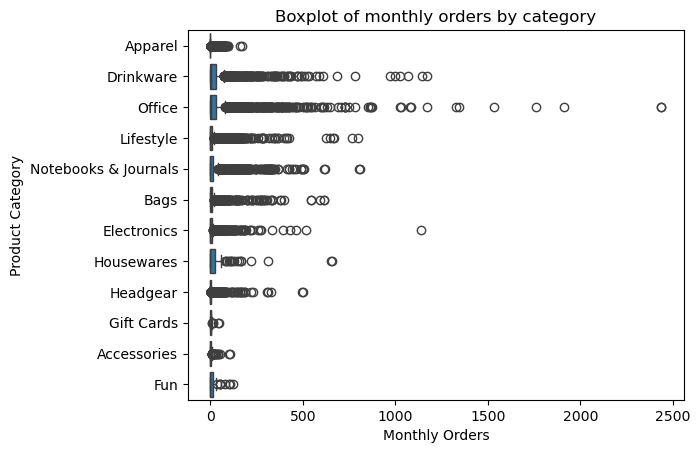

In [41]:
sns.boxplot(x = all_months_products['present_total_qty'], y = all_months_products['product_category'])
plt.title('Boxplot of monthly orders by category')
plt.xlabel('Monthly Orders')
plt.ylabel('Product Category')

Text(0, 0.5, 'Product Category')

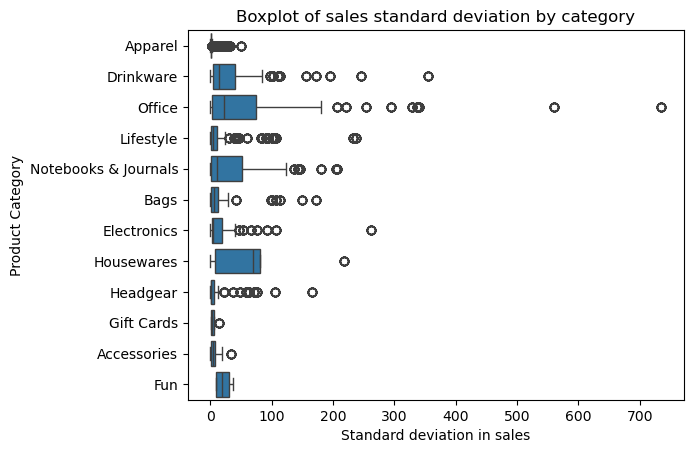

In [42]:
sns.boxplot(x = all_months_products['total_qty_sd'], y = all_months_products['product_category'])
plt.title('Boxplot of sales standard deviation by category')
plt.xlabel('Standard deviation in sales')
plt.ylabel('Product Category')

Text(0, 0.5, 'Product Category')

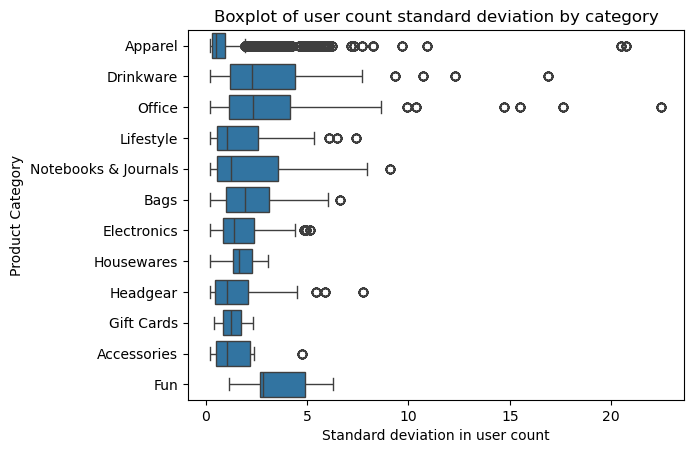

In [43]:
sns.boxplot(x = all_months_products['user_cnt_sd'], y = all_months_products['product_category'])
plt.title('Boxplot of user count standard deviation by category')
plt.xlabel('Standard deviation in user count')
plt.ylabel('Product Category')

### 5. Feature engineering

##### Lag quantity and user count

In [44]:
#Create columns for lag qty, lag user count, rolling window avg qty & rolling window  user count
all_months_products = all_months_products.sort_values(['product_id', 'product_price', 'year_month'])
all_months_products['prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(1)
all_months_products['prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(1)
all_months_products['prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(2)
all_months_products['prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(2)
all_months_products['prev_prev_prev_total_qty'] = all_months_products.groupby(['product_id','product_price'])['present_total_qty'].shift(3)
all_months_products['prev_prev_prev_user_cnt'] = all_months_products.groupby(['product_id','product_price'])['present_user_cnt'].shift(3)
all_months_products.dropna(inplace = True)
all_months_products['avg_2m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'])/2
all_months_products['avg_3m_user_cnt'] = (all_months_products['prev_user_cnt'] + all_months_products['prev_prev_user_cnt'] + all_months_products['prev_prev_prev_user_cnt'])/3
all_months_products['avg_2m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'])/2
all_months_products['avg_3m_total_qty'] = (all_months_products['prev_total_qty'] + all_months_products['prev_prev_total_qty'] + all_months_products['prev_prev_prev_total_qty'])/3
all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']] = all_months_products[['product_price','avg_2m_user_cnt','avg_3m_user_cnt','avg_2m_total_qty','avg_3m_total_qty']].apply(lambda x: x.round(2), axis = 0)

Text(0.5, 1.0, 'Correlation Heatmap of Lag Demand')

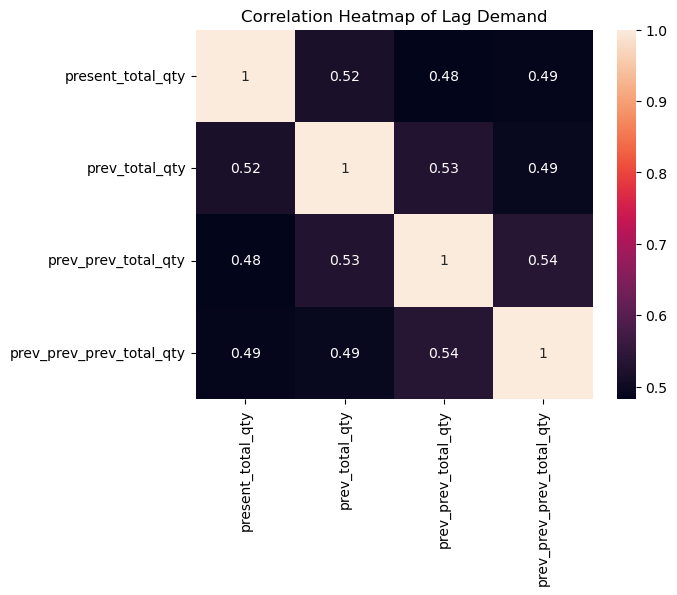

In [45]:
qty_corr = all_months_products[['present_total_qty', 'prev_total_qty', 'prev_prev_total_qty','prev_prev_prev_total_qty']].corr()
sns.heatmap(qty_corr, annot = True)
plt.title('Correlation Heatmap of Lag Demand')

##### Indicators for holidays/peak periods

In [46]:
#Add indicators for holidays/peak periods (https://quivo.co/us/amazon-peak-season-most-important-e-commerce-days-2024/)
all_months_products["peak_period"] = all_months_products["month"].isin(["Nov", "Dec"]).astype(int)
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
holidays = [0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1]
month_holidays = pd.DataFrame({"month": month, "holidays": holidays})
all_months_products = all_months_products.merge(month_holidays, on = "month", how = "left")

In [47]:
season = pd.DataFrame({"month": month, "season": ["Winter", "Winter", "Spring", "Spring", "Spring", "Summer", "Summer", "Summer", "Fall", "Fall", "Fall", "Winter"]})
all_months_products = pd.merge(all_months_products, season, on = "month", how = "left")

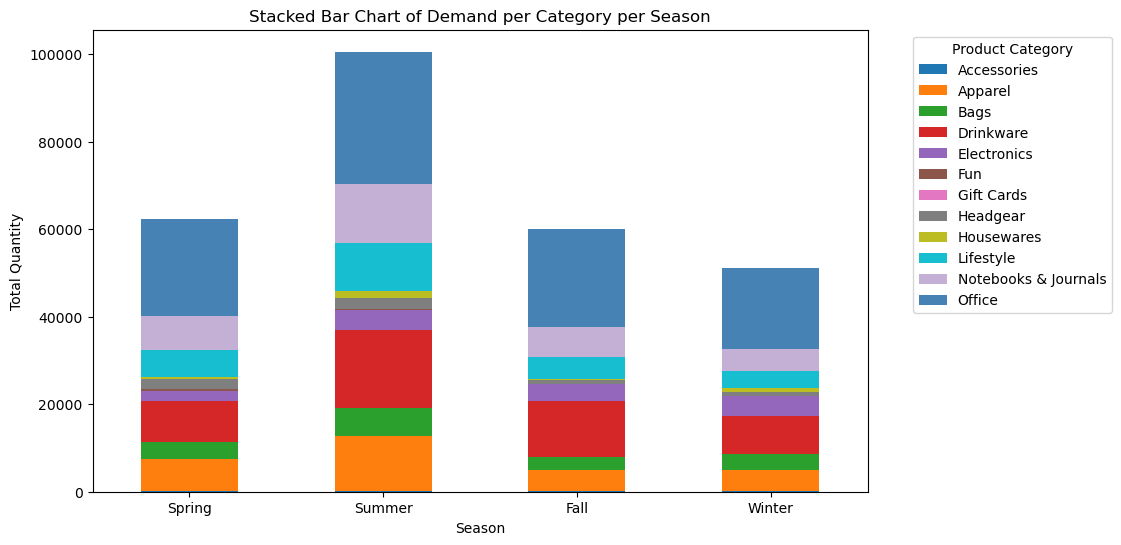

In [48]:
season_ordered = all_months_products.copy()
season_ordered['season'] = pd.Categorical(season_ordered['season'], categories = ['Spring', 'Summer', 'Fall', 'Winter'], ordered = True)
ax3 = season_ordered.groupby(['season','product_category'])['present_total_qty'].sum().unstack().plot(kind='bar', stacked=True, figsize=(10, 6), color = colors)
# ax3.set_xticklabels(all_months_products['season'].unique())
plt.ylabel('Total Quantity')
plt.xlabel('Season')
plt.title('Stacked Bar Chart of Demand per Category per Season')
plt.xticks(rotation=0)  # Rotate x-ticks for better readability
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')

##### Variation in demand (XYZ analysis)

In [49]:
qty_sd = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].std().reset_index(name = 'total_qty_sd')
qty_mean = all_months_products.groupby(['product_id', 'product_price'])['present_total_qty'].mean().reset_index(name = 'total_qty_mean')
qty_stats = pd.merge(qty_sd, qty_mean, on = ['product_id', 'product_price'], how = 'left')
qty_stats['total_qty_cv'] = qty_stats['total_qty_sd']/qty_stats['total_qty_mean']

user_cnt_sd = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].std().reset_index(name = 'user_cnt_sd')
user_cnt_mean = all_months_products.groupby(['product_id', 'product_price'])['present_user_cnt'].mean().reset_index(name = 'user_cnt_mean')
user_cnt_stats = pd.merge(user_cnt_sd, user_cnt_mean, on = ['product_id', 'product_price'], how = 'left')
user_cnt_stats['user_cnt_cv'] = user_cnt_stats['user_cnt_sd']/user_cnt_stats['user_cnt_mean']

all_months_products = all_months_products.merge(qty_stats, on = ['product_id', 'product_price'], how = 'left')
all_months_products = all_months_products.merge(user_cnt_stats, on = ['product_id', 'product_price'], how = 'left')
all_months_products['total_qty_log'] = np.log1p(all_months_products['present_total_qty'])

<Axes: xlabel='total_qty_cv', ylabel='Density'>

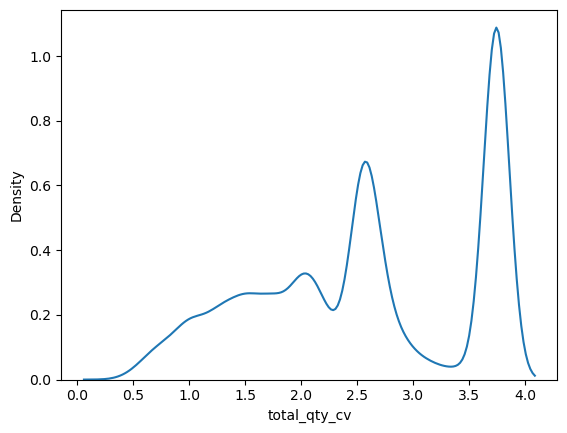

In [50]:
sns.kdeplot(x = 'total_qty_cv', data = all_months_products)

In [51]:
kmeans = KMeans(n_clusters=3, random_state = 123)
kmeans.fit(all_months_products[['total_qty_cv']])
labels = kmeans.labels_
all_months_products['xyz_cat'] = labels

In [52]:
all_months_products.groupby('xyz_cat')['total_qty_cv'].describe()

,count,mean,std,min,25%,50%,75%,max
xyz_cat,,,,,,,,
0,17626.0,2.441357,0.287711,1.879728,2.139374,2.541956,2.600592,3.039021
1,14602.0,3.71343,0.115151,3.086613,3.741657,3.741657,3.741657,3.741657
2,11900.0,1.311269,0.350886,0.405117,1.035587,1.343989,1.596293,1.875506


<Axes: xlabel='xyz_cat', ylabel='total_qty_cv'>

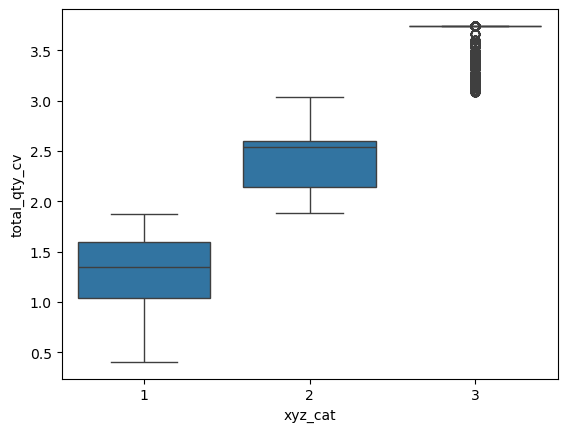

In [53]:
all_months_products['xyz_cat'] = all_months_products['xyz_cat'].replace({0:2, 1:3, 2:1})
sns.boxplot(data = all_months_products, x = 'xyz_cat', y = 'total_qty_cv')

### 6. Feature selection

In [54]:
model_df = all_months_products.copy()
model_columns = ['month','product_id', 'product_category', 'product_price', 'holidays', 'season', 'xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt', 'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty', 'avg_3m_total_qty']

test_df = model_df.loc[model_df["year_month"] == '2017-07-01']
val_df = model_df.loc[model_df["year_month"] == '2017-06-01']
train_df = model_df.loc[~model_df["year_month"].isin(['2017-07-01', '2017-06-01'])]

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

X_train = train_df[model_columns]
X_train['month'] = pd.Categorical(X_train['month'], categories = all_months)
X_train['season'] = pd.Categorical(X_train['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_train = pd.get_dummies(X_train, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)
y_train = train_df['present_total_qty']

X_test = test_df[model_columns]
X_test['month'] = pd.Categorical(X_test['month'], categories = all_months)
X_test['season'] = pd.Categorical(X_test['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_test = pd.get_dummies(X_test, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_test = test_df['present_total_qty']

X_val = val_df[model_columns]
X_val['month'] = pd.Categorical(X_val['month'], categories = all_months)
X_val['season'] = pd.Categorical(X_val['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_val = pd.get_dummies(X_val, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_val = val_df['present_total_qty']

#### RFECV

In [55]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [100]:
#For efficiency, the selected features are saved in selected_columns

rf_rfecv = RandomForestRegressor(random_state = 999, n_jobs = -1, n_estimators = 100, max_features = 5)
selector = RFECV(estimator = rf_rfecv, step = 0.15, cv = 5, n_jobs = -1, scoring = rmse_scorer, verbose = 2)
selector.fit(X_train, y_train)
selected_columns = X_train.columns[selector.support_]

# selected_columns = ['product_price', 'holidays', 'xyz_cat', 'peak_period', 'prev_user_cnt', 'prev_total_qty', 'prev_prev_user_cnt',
#                      'prev_prev_total_qty', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 
#                      'avg_2m_total_qty', 'avg_3m_total_qty', 'product_category_Apparel', 'product_category_Bags', 'product_category_Drinkware',
#                        'product_category_Electronics', 'product_category_Headgear', 'product_category_Housewares', 'product_category_Lifestyle',
#                         'product_category_Notebooks & Journals', 'product_category_Office', 'product_id_GGOEADHH055999', 
#                         'product_id_GGOEADWQ015699', 'product_id_GGOEAFKQ020499', 'product_id_GGOEAFKQ020599', 'product_id_GGOEAHPJ074410', 
#                         'product_id_GGOEAKDH019899', 'product_id_GGOEAOCH077899', 'product_id_GGOEGAAQ010415', 'product_id_GGOEGBFC018799', 
#                         'product_id_GGOEGBJC019999', 'product_id_GGOEGBJL013999', 'product_id_GGOEGBJR018199', 'product_id_GGOEGBMJ013399', 
#                         'product_id_GGOEGCBC074299', 'product_id_GGOEGCBQ016499', 'product_id_GGOEGCKQ013199', 'product_id_GGOEGDHA018899', 
#                         'product_id_GGOEGDHC018299', 'product_id_GGOEGDHC074099', 'product_id_GGOEGDHQ014899', 'product_id_GGOEGDHQ015399', 
#                         'product_id_GGOEGDHR018499', 'product_id_GGOEGDWC020199', 'product_id_GGOEGDWR015799', 'product_id_GGOEGESC014099', 
#                         'product_id_GGOEGETR014599', 'product_id_GGOEGEVR014999', 'product_id_GGOEGFAQ016699', 'product_id_GGOEGFKA022299', 
#                         'product_id_GGOEGFKQ020399', 'product_id_GGOEGFKQ020799', 'product_id_GGOEGFSR022099', 'product_id_GGOEGFYQ016599', 
#                         'product_id_GGOEGGOA017399', 'product_id_GGOEGHGC019799', 'product_id_GGOEGHGH019699', 'product_id_GGOEGHGR019499',
#                         'product_id_GGOEGHPB071610', 'product_id_GGOEGHPJ080110', 'product_id_GGOEGKAA019299', 'product_id_GGOEGOAA017099', 
#                         'product_id_GGOEGOAA017199', 'product_id_GGOEGOAB012999', 'product_id_GGOEGOAB015899', 'product_id_GGOEGOAB021699', 
#                         'product_id_GGOEGOAC021799', 'product_id_GGOEGOAJ021599', 'product_id_GGOEGOAQ012899', 'product_id_GGOEGOAQ015999', 
#                         'product_id_GGOEGOAQ018099', 'product_id_GGOEGOAQ020099', 'product_id_GGOEGOAR013099', 'product_id_GGOEGOAR013599', 
#                         'product_id_GGOEGOAR021899', 'product_id_GGOEGOAR021999', 'product_id_GGOEGOBG023599', 'product_id_GGOEGOCB017499', 
#                         'product_id_GGOEGOCC017599', 'product_id_GGOEGOCC017699', 'product_id_GGOEGOCC077999', 'product_id_GGOEGOCL077699', 
#                         'product_id_GGOEGOCR017899', 'product_id_GGOEGOCT019199', 'product_id_GGOEGODR017799', 'product_id_GGOEGOFH020299', 
#                         'product_id_GGOEGOGA016299', 'product_id_GGOEGOLC013299', 'product_id_GGOEGOLC014299', 'product_id_GGOEGOXQ016399', 
#                         'product_id_GGOEGPJC019099', 'product_id_GGOEGPJR018999', 'product_id_GGOEWFKA083199', 'product_id_GGOEYDHJ019399', 
#                         'product_id_GGOEYDHJ056099', 'product_id_GGOEYFKQ020699', 'product_id_GGOEYHPB072210', 'product_id_GGOEYOCR077799', 
#                         'product_id_GGOEYOCR078099', 'product_id_GGOEYOLR018699', 'product_id_GGOEYOLR080599', 'month_Feb', 'month_Mar', 
#                         'month_Apr', 'month_May', 'month_Jun', 'month_Jul', 'month_Aug', 'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 
#                         'season_Spring', 'season_Summer', 'season_Fall']

X_train_rfecv = X_train[selected_columns]
X_val_rfecv = X_val[selected_columns]
X_test_rfecv = X_test[selected_columns]


Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 291 features.
Fitting estimator with 291 featur

In [101]:
X_train_rfecv.shape

(37824, 291)

### 7. Model training

#### Random forest

In [70]:
rf = RandomForestRegressor(random_state = 123)
param_grid = {
    'max_depth': [15, 20],
    'max_features': [15, 20],
    'min_samples_split': [25, 30],
    'n_estimators': [150, 200, 250],
    'min_samples_leaf': [2, 5]
}
rf_rmse_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring=rmse_scorer)
rf_rmse_grid_search.fit(X_train_rfecv, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=150; total time=   7.1s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=150; total time=   7.5s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=150; total time=   7.5s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=150; total time=   7.7s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=150; total time=   7.7s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=200; total time=   9.7s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=200; total time=   9.7s
[CV] END max_depth=15, max_features=15, min_samples_leaf=2, min_samples_split=25, n_estimators=200; total

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [15, 20], 'max_features': [15, 20],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [25, 30],
                         'n_estimators': [150, 200, 250]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=2)

In [71]:
print(rf_rmse_grid_search.best_params_)
rf_rmse_best_model = rf_rmse_grid_search.best_estimator_

# rf_rmse_best_model = RandomForestRegressor(max_depth=20, max_features=20, min_samples_split=20, min_samples_leaf = 5, 
#                                            n_estimators=150, random_state=123)
# rf_rmse_best_model.fit(X_train_rfecv, y_train)

y_train_pred = rf_rmse_best_model.predict(X_train_rfecv)
print(f'Train RMSE: {round(mean_squared_error(y_train, y_train_pred, squared = False), 2)}')

y_val_pred = rf_rmse_best_model.predict(X_val_rfecv)
print(f'Validation RMSE: {round(mean_squared_error(y_val, y_val_pred, squared = False), 2)}')

importance_rf_rmse_df= pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': rf_rmse_best_model.feature_importances_
})

importance_rf_rmse_df.sort_values(by='Importance', ascending=False)[:10]


{'max_depth': 15, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 250}
Train RMSE: 28.75
Validation RMSE: 46.5


,Feature,Importance
13,avg_3m_total_qty,0.125397
12,avg_2m_total_qty,0.125102
7,prev_prev_total_qty,0.092965
5,prev_total_qty,0.079801
9,prev_prev_prev_total_qty,0.078972
0,product_price,0.070788
11,avg_3m_user_cnt,0.064820
10,avg_2m_user_cnt,0.054126
197,product_id_GGOEGGOA017399,0.053334
4,prev_user_cnt,0.046382


<Axes: xlabel='present_total_qty', ylabel='Count'>

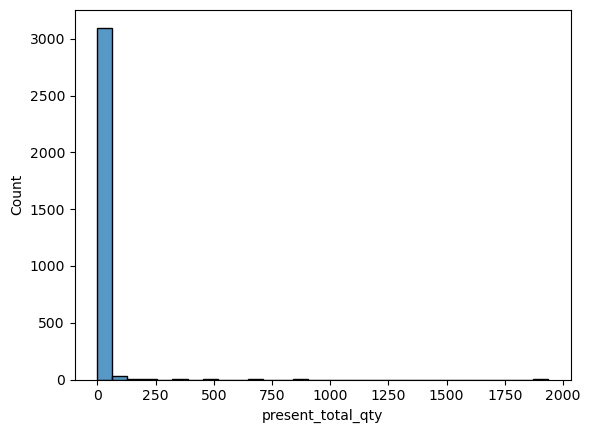

In [72]:
test_error = abs(y_val_pred - y_val)
sns.histplot(test_error, bins = 30)

### XGBoost

In [76]:
xgboost = xgb.XGBRegressor(random_state=123, learning_rate = 0.01)

param_grid = {
    'max_depth': [8, 10, 12],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9],
    'n_estimators': [150, 200, 250],
    'gamma': [0.95, 1],
    'reg_lambda': [15, 20]
}
xgb_grid_search = GridSearchCV(estimator = xgboost, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')
xgb_grid_search.fit(X_train_rfecv, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.8; total time=   9.3s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.8; total time=   9.5s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.9; total time=   9.5s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, reg_lambda=15, subsample=0.9; total time=   9.6s
[CV] END colsample_bytree=0.8, gamma=0.95, max_depth=8, n_estimators=150, re

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.95,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.01, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9], 'gamma': [0.95, 1],
                         'max_depth': [8, 10, 12],
                         'n_estimators': [150, 200, 250],
                         'reg_lambda': [15, 20], 'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [78]:
# xgb_best_model = xgb.XGBRegressor(random_state=123, colsample_by_tree = 0.8, gamma = 0.95, reg_lambda = 15,
#                                   learning_rate = 0.01, max_depth = 10, n_estimators = 250, subsample = 0.8)
# xgb_best_model.fit(X_train_rfecv, y_train)

print(f'Chosen hyperparameters: {xgb_grid_search.best_params_}')
xgb_best_model = xgb_grid_search.best_estimator_

y_train_pred = xgb_best_model.predict(X_train_rfecv)
train_errors = abs(y_train - y_train_pred)
print(f'Train RMSE: {round(mean_squared_error(y_train, y_train_pred, squared = False), 2)}')
print(f'Train MAE: {round(np.mean(abs(y_train - y_train_pred)), 2)}')


y_val_pred = xgb_best_model.predict(X_val_rfecv)
val_errors = abs(y_val - y_val_pred)
print(f'Validation RMSE: {round(mean_squared_error(y_val, y_val_pred, squared = False), 2)}')
print(f'Validation MAE: {round(np.mean(abs(y_val - y_val_pred)), 2)}')

importance_xgb_df = pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': xgb_best_model.feature_importances_
})

importance_xgb_df.sort_values(by='Importance', ascending=False)[:10]


Chosen hyperparameters: {'colsample_bytree': 0.9, 'gamma': 0.95, 'max_depth': 8, 'n_estimators': 250, 'reg_lambda': 15, 'subsample': 0.8}
Train RMSE: 27.0
Train MAE: 4.56
Validation RMSE: 44.27
Validation MAE: 5.32


,Feature,Importance
197,product_id_GGOEGGOA017399,0.293649
13,avg_3m_total_qty,0.139653
12,avg_2m_total_qty,0.048728
157,product_id_GGOEGDHC018299,0.033896
247,product_id_GGOEGODR017799,0.016092
195,product_id_GGOEGFYQ016599,0.015922
167,product_id_GGOEGDHR018499,0.015903
223,product_id_GGOEGOAC021799,0.015376
5,prev_total_qty,0.015207
282,month_Jul,0.014445


Text(0.5, 0, 'Validation error')

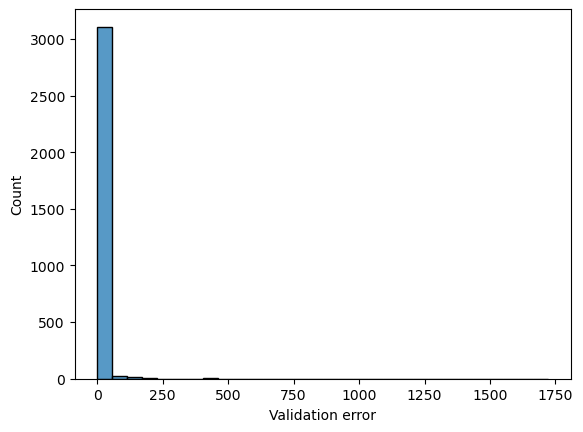

In [175]:
val_error = abs(y_val_pred - y_val)
sns.histplot(val_error, bins = 30)
plt.xlabel('Validation error')

<Axes: xlabel='y_val', ylabel='error'>

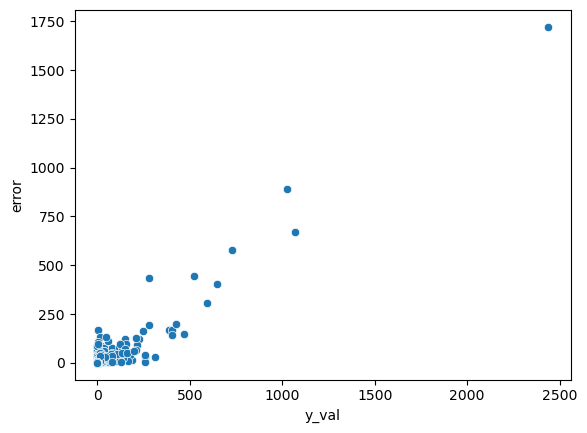

In [176]:
error_qty_df = pd.DataFrame({'y_val': y_val, 'error': abs(y_val_pred - y_val)})
sns.scatterplot(data = error_qty_df, x = 'y_val', y = 'error')

#### XGBoost Distribution

This allows us to generate a probability distribution for monthly demand, which will be beneficial for keeping different buffer levels.

In [82]:
def rmse_xgbd(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred[0]))

rmse_scorer_xgbd = make_scorer(rmse_xgbd, greater_is_better=False)

In [90]:
param_grid = {
    'max_depth': [12, 15],
    'subsample': [0.8, None],
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.018, 0.02],
    'reg_lambda': [3, 5]
}

xgbd = XGBDistribution(distribution = 'poisson', random_state = 123, gamma = 1)

xgbd_grid_search = GridSearchCV(estimator = xgbd, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring = rmse_scorer_xgbd)
xgbd_grid_search.fit(X_train_rfecv, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=0.8; total time=  13.7s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=0.8; total time=  14.0s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=0.8; total time=  14.0s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=0.8; total time=  14.4s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=0.8; total time=  14.4s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=None; total time=  14.5s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=None; total time=  14.7s
[CV] END learning_rate=0.018, max_depth=12, n_estimators=150, reg_lambda=3, subsample=None; total time=  15.0s
[CV] END learning_rate=0.018, max_depth=12, n_estimator

GridSearchCV(cv=5,
             estimator=XGBDistribution(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None, device=None,
                                       distribution='poisson',
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=1, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=No...
                                       missing=nan, monotone_constraints=None,
                                       multi_strategy=None, n_estimators=None,
                                       n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.018, 0.02], 'max_depth': [12, 15],
                         'n_estimators': [150, 200, 250], 'reg_lambda': [3, 5],
                         'subsample': [0.8, None]},
             scoring=make_scorer(rmse_xgbd, greater_is_better=False, response_method='predict'),
             verbose=2)

In [91]:
# xgbd_best_model = XGBDistribution(distribution = 'poisson', random_state = 123, 
#                                   gamma = 1, reg_lambda = 3,
#                                   learning_rate = 0.02, max_depth = 15, n_estimators = 200, subsample = None)
# xgbd_best_model.fit(X_train_rfecv, y_train)

print(f'Chosen hyperparameters: {xgbd_grid_search.best_params_}')
xgbd_best_model = xgbd_grid_search.best_estimator_
# print(xgbd_best_model_cv.get_params())
# print(xgbd_best_model.get_params())

y_train_pred = xgbd_best_model.predict(X_train_rfecv)[0]
train_errors = abs(y_train - y_train_pred)
print(f'Train RMSE: {round(mean_squared_error(y_train, y_train_pred, squared = False), 2)}')
print(f'Train MAE: {round(np.mean(abs(y_train - y_train_pred)), 2)}')


y_val_pred = xgbd_best_model.predict(X_val_rfecv)[0]
val_errors = abs(y_val - y_val_pred)
print(f'Validation RMSE: {round(mean_squared_error(y_val, y_val_pred, squared = False), 2)}')
print(f'Validation MAE: {round(np.mean(abs(y_val - y_val_pred)), 2)}')

importance_xgbd_df = pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': xgbd_best_model.feature_importances_
})

importance_xgbd_df.sort_values(by='Importance', ascending=False)[:10]


Chosen hyperparameters: {'learning_rate': 0.018, 'max_depth': 15, 'n_estimators': 200, 'reg_lambda': 3, 'subsample': None}
Train RMSE: 19.03
Train MAE: 2.55
Validation RMSE: 32.12
Validation MAE: 3.86


,Feature,Importance
197,product_id_GGOEGGOA017399,0.550293
157,product_id_GGOEGDHC018299,0.393114
223,product_id_GGOEGOAC021799,0.008769
244,product_id_GGOEGOCR017899,0.007385
13,avg_3m_total_qty,0.004845
2,xyz_cat,0.004530
248,product_id_GGOEGOFH020299,0.002693
228,product_id_GGOEGOAQ020099,0.001218
217,product_id_GGOEGOAB015899,0.001178
195,product_id_GGOEGFYQ016599,0.001046


<Axes: xlabel='y_val', ylabel='error'>

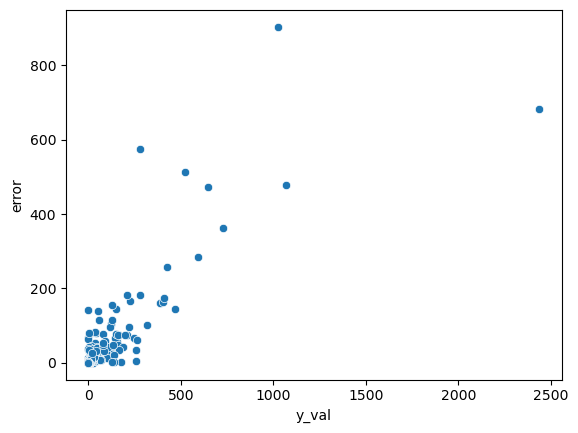

In [215]:
error_qty_df = pd.DataFrame({'y_val': y_val, 'error': abs(y_val_pred - y_val)})
sns.scatterplot(data = error_qty_df, x = 'y_val', y = 'error')

### 7.1 Model Building (with log transformation)

Oftentimes the MAE is a lot lower than the RMSE and the distribution of validation error is extremely right skewed. The plot of error against true values has also shown that large errors tend to be for products with high demand. This suggests that perhaps applying log transformation on the demand will help improve the model performance.

In [93]:
all_months_products['present_total_qty_log'] = np.log1p(all_months_products['present_total_qty'] + 1)
all_months_products['prev_total_qty_log'] = np.log1p(all_months_products['prev_total_qty'] + 1)
all_months_products['prev_prev_total_qty_log'] = np.log1p(all_months_products['prev_prev_total_qty'] + 1)
all_months_products['prev_prev_prev_total_qty_log'] = np.log1p(all_months_products['prev_prev_prev_total_qty'] + 1)
all_months_products['avg_2m_total_qty_log'] = np.log1p(all_months_products['avg_2m_total_qty'] + 1)
all_months_products['avg_3m_total_qty_log'] = np.log1p(all_months_products['avg_3m_total_qty'] + 1)


In [94]:
model_log_df = all_months_products.copy()
model_log_columns = ['month','product_id', 'product_category', 'product_price', 'holidays', 'season', 'xyz_cat','peak_period','prev_user_cnt', 'prev_total_qty_log', 'prev_prev_user_cnt', 'prev_prev_total_qty_log', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty_log', 'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty_log', 'avg_3m_total_qty_log']

test_log_df = model_log_df.loc[model_log_df["year_month"] == '2017-07-01']
val_log_df = model_log_df.loc[model_log_df["year_month"] == '2017-06-01']
train_log_df = model_log_df.loc[~model_log_df["year_month"].isin(['2017-07-01', '2017-06-01'])]

all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

X_train_log = train_log_df[model_log_columns]
X_train_log['month'] = pd.Categorical(X_train_log['month'], categories = all_months)
X_train_log['season'] = pd.Categorical(X_train_log['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_train_log = pd.get_dummies(X_train_log, columns = ['product_category', 'product_id', 'month','season'], drop_first = True)
y_train_log = train_log_df['present_total_qty_log']

X_test_log = test_log_df[model_log_columns]
X_test_log['month'] = pd.Categorical(X_test_log['month'], categories = all_months)
X_test_log['season'] = pd.Categorical(X_test_log['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_test_log = pd.get_dummies(X_test_log, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_test_log = test_log_df['present_total_qty_log']

X_val_log = val_log_df[model_log_columns]
X_val_log['month'] = pd.Categorical(X_val_log['month'], categories = all_months)
X_val_log['season'] = pd.Categorical(X_val_log['season'], categories = ['Winter', 'Spring', 'Summer', 'Fall'])
X_val_log = pd.get_dummies(X_val_log, columns = ['product_category', 'product_id', 'month', 'season'], drop_first = True)
y_val_log = val_log_df['present_total_qty_log']

In [95]:
def log_rmse(y_true, y_pred):

    return np.sqrt(mean_squared_error(np.exp(y_true), np.exp(y_pred)))

log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)

In [96]:
log_rfecv = RandomForestRegressor(random_state = 999, n_jobs = -1, n_estimators = 100, max_features = 5)
selector_log = RFECV(estimator = log_rfecv, step = 0.15, cv = 5, n_jobs = -1, scoring = log_rmse_scorer, verbose = 2)
selector_log.fit(X_train_log, y_train_log)
selected_columns_log = X_train_log.columns[selector_log.support_]

# selected_columns_log = ['product_price', 'holidays', 'xyz_cat', 'peak_period', 'prev_user_cnt', 'prev_total_qty_log', 
#                               'prev_prev_user_cnt', 'prev_prev_total_qty_log', 'prev_prev_prev_user_cnt', 'prev_prev_prev_total_qty_log', 
#                               'avg_2m_user_cnt', 'avg_3m_user_cnt', 'avg_2m_total_qty_log', 'avg_3m_total_qty_log', 'product_category_Apparel', 
#                               'product_category_Bags', 'product_category_Drinkware', 'product_category_Electronics', 'product_category_Fun', 
#                               'product_category_Headgear', 'product_category_Housewares', 'product_category_Lifestyle', 
#                               'product_category_Notebooks & Journals', 'product_category_Office', 'product_id_GGOEAHPJ074410', 
#                               'product_id_GGOEAKDH019899', 'product_id_GGOEGAAB033815', 'product_id_GGOEGAAQ010415', 'product_id_GGOEGAFB035813', 
#                               'product_id_GGOEGAWQ062948', 'product_id_GGOEGAWQ062949', 'product_id_GGOEGAWQ062953', 'product_id_GGOEGBFC018799', 
#                               'product_id_GGOEGBJC014399', 'product_id_GGOEGBJC019999', 'product_id_GGOEGBJR018199', 'product_id_GGOEGBMJ013399', 
#                               'product_id_GGOEGBPB021199', 'product_id_GGOEGCBQ016499', 'product_id_GGOEGCKQ013199', 'product_id_GGOEGDHC015299', 
#                               'product_id_GGOEGDHC018299', 'product_id_GGOEGDHG014499', 'product_id_GGOEGDHJ082599', 'product_id_GGOEGDHQ015399', 
#                               'product_id_GGOEGDHR018499', 'product_id_GGOEGDHR082199', 'product_id_GGOEGDWC020199', 'product_id_GGOEGDWR015799', 
#                               'product_id_GGOEGEFR024199', 'product_id_GGOEGETR014599', 'product_id_GGOEGEVR014999', 'product_id_GGOEGFAQ016699', 
#                               'product_id_GGOEGFKA022299', 'product_id_GGOEGFKQ020399', 'product_id_GGOEGFKQ020799', 'product_id_GGOEGFQB013799', 
#                               'product_id_GGOEGFSR022099', 'product_id_GGOEGFYQ016599', 'product_id_GGOEGGOA017399', 'product_id_GGOEGHGH019699', 
#                               'product_id_GGOEGHGT019599', 'product_id_GGOEGKAA019299', 'product_id_GGOEGOAA017099', 'product_id_GGOEGOAA017199', 
#                               'product_id_GGOEGOAB012999', 'product_id_GGOEGOAB015899', 'product_id_GGOEGOAB016099', 'product_id_GGOEGOAB021699', 
#                               'product_id_GGOEGOAC021799', 'product_id_GGOEGOAQ012899', 'product_id_GGOEGOAQ015999', 'product_id_GGOEGOAQ018099', 
#                               'product_id_GGOEGOAQ020099', 'product_id_GGOEGOAR013099', 'product_id_GGOEGOAR013599', 'product_id_GGOEGOAR021899', 
#                               'product_id_GGOEGOAR021999', 'product_id_GGOEGOBC078699', 'product_id_GGOEGOBG023599', 'product_id_GGOEGOCB017499', 
#                               'product_id_GGOEGOCC017599', 'product_id_GGOEGOCC017699', 'product_id_GGOEGOCC077299', 'product_id_GGOEGOCC077999', 
#                               'product_id_GGOEGOCL077699', 'product_id_GGOEGOCR017899', 'product_id_GGOEGOCT019199', 'product_id_GGOEGODR017799', 
#                               'product_id_GGOEGOFH020299', 'product_id_GGOEGOGA016299', 'product_id_GGOEGOLC013299', 'product_id_GGOEGOLC014299', 
#                               'product_id_GGOEGOXQ016399', 'product_id_GGOEGPJR018999', 'product_id_GGOEYDHJ019399', 'product_id_GGOEYFKQ020699', 
#                               'product_id_GGOEYHPB072210', 'product_id_GGOEYOBR078599', 'product_id_GGOEYOCR077799', 'product_id_GGOEYOCR078099', 
#                               'product_id_GGOEYOLR018699', 'product_id_GGOEYOLR080599', 'month_Feb', 'month_Mar', 'month_Apr', 'month_May', 'month_Jun', 
#                               'month_Jul', 'month_Aug', 'month_Sep', 'month_Oct', 'month_Nov', 'month_Dec', 'season_Spring', 'season_Summer', 'season_Fall']

X_train_log_rfecv = X_train_log[selected_columns_log]
X_val_log_rfecv = X_val_log[selected_columns_log]
X_test_log_rfecv = X_test_log[selected_columns_log]

Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 1156 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 983 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 810 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 637 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 464 features.
Fitting estimator with 291 features.
Fitting estimator with 291 featur

#### Random forest

In [98]:
rf_log = RandomForestRegressor(random_state = 123)
param_grid = {
    'max_depth': [20, 25],
    'max_features': [20, 25],
    'min_samples_split': [10, 15],
    'n_estimators': [150, 200, 250]
}
rf_log_grid_search = GridSearchCV(estimator = rf_log, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2,
                          scoring=rmse_scorer)
rf_log_grid_search.fit(X_train_log_rfecv, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=150; total time=  10.5s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=150; total time=  11.6s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=150; total time=  12.3s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=150; total time=  12.6s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=150; total time=  12.5s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=200; total time=  16.2s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=200; total time=  16.5s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=200; total time=  16.6s
[CV] END max_depth=20, max_features=20, min_samples_split=10, n_estimators=200; total time=  14.1s
[CV] END max_depth=20, max_features=20, min_sam

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [20, 25], 'max_features': [20, 25],
                         'min_samples_split': [10, 15],
                         'n_estimators': [150, 200, 250]},
             scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
             verbose=2)

In [99]:
# print(f'Chosen hyperparameters: {rf_log_grid_search.best_params_}')
# print(f'Set of hyperparameters: {rf_log_grid_search.get_params()}')
print(rf_log_grid_search.best_params_)
rf_log_best_model = rf_log_grid_search.best_estimator_

# rf_log_best_model = RandomForestRegressor(max_depth=25, max_features=20, min_samples_split=15, n_estimators=200, random_state=123)
rf_log_best_model.fit(X_train_log_rfecv, y_train_log)

y_train_pred = rf_log_best_model.predict(X_train_log_rfecv)
print(f'Train RMSE: {round(mean_squared_error(np.exp(y_train_log), np.exp(y_train_pred), squared = False), 2)}')

y_val_pred = rf_log_best_model.predict(X_val_log_rfecv)
print(f'Validation RMSE: {round(mean_squared_error(np.exp(y_val_log), np.exp(y_val_pred), squared = False), 2)}')

importance_rf_log_df= pd.DataFrame({
    'Feature': X_train_log_rfecv.columns,
    'Importance': rf_log_best_model.feature_importances_
})

importance_rf_log_df.sort_values(by='Importance', ascending=False)[:10]

{'max_depth': 25, 'max_features': 25, 'min_samples_split': 15, 'n_estimators': 150}
Train RMSE: 30.38
Validation RMSE: 49.72


,Feature,Importance
13,avg_3m_total_qty_log,0.162281
12,avg_2m_total_qty_log,0.142008
5,prev_total_qty_log,0.111147
11,avg_3m_user_cnt,0.101081
0,product_price,0.071082
10,avg_2m_user_cnt,0.064637
7,prev_prev_total_qty_log,0.052989
2,xyz_cat,0.049852
9,prev_prev_prev_total_qty_log,0.048162
4,prev_user_cnt,0.040483


<Axes: xlabel='y_val', ylabel='error'>

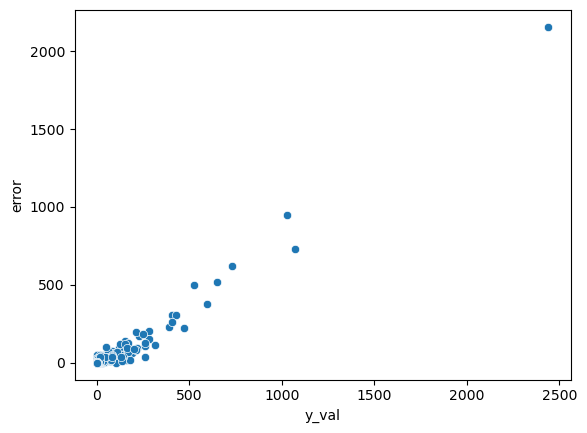

In [238]:
error_qty_df = pd.DataFrame({'y_val': np.exp(y_val_log), 'error': abs(np.exp(y_val_pred) - np.exp(y_val_log))})
sns.scatterplot(data = error_qty_df, x = 'y_val', y = 'error')

### 8. Final Model

We choose the XGB Distribution model as it has the lowest validaiton error and provides a probability distribution, which will be useful when deciding what level of risk the inventory optimization model will take for different types of products

In [92]:
y_test_pred = xgbd_best_model.predict(X_test_rfecv)[0]
test_errors = abs(y_test - y_test_pred)
print(f'Test RMSE: {round(mean_squared_error(y_test, y_test_pred, squared = False), 2)}')
print(f'Test MAE: {round(np.mean(abs(y_test - y_test_pred)), 2)}')

Test RMSE: 21.02
Test MAE: 3.84


In [240]:
importance_xgbd_df = pd.DataFrame({
    'Feature': X_train_rfecv.columns,
    'Importance': xgbd_best_model.feature_importances_
})

importance_rf_log_df.sort_values(by='Importance', ascending=False)[:10]

,Feature,Importance
13,avg_3m_total_qty_log,0.172005
12,avg_2m_total_qty_log,0.141327
5,prev_total_qty_log,0.111023
11,avg_3m_user_cnt,0.089258
0,product_price,0.066781
10,avg_2m_user_cnt,0.061767
7,prev_prev_total_qty_log,0.054735
2,xyz_cat,0.050938
9,prev_prev_prev_total_qty_log,0.048393
4,prev_user_cnt,0.040949
